### Make predictions

This script takes a trained Convolutional Neural Network model and a folder full of fossil images as inputs.  As output, it returns predictions of the scientific names of each fossil image.  The output can be formatted in two ways:  1. as thumbnails of each image with the predicted name written above each and/or 2. as a CSV file where each line contains an input fossil image's filename and predicted scientific name

### Imports

In [21]:
import image_helpers as ih
import pickle
import os
import shutil
from pathlib import Path
from PIL import Image, ImageOps

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing import image
import numpy as np


### Set parameters

In [22]:
model_filepath = '../model/best_model_checkpoint_2021-02-15-17-23.hdf5'
label_filepath = '../model/labels.txt'
output_file = '../model/output.csv'
img_width, img_height = 224, 224


### Resize the input files

The EfficientNetB1 model expects 224x224 images during training.  It will stretch/squeeze the images into that size.  This introduces distortions that make the classification task less accurate.  To counter that, before training, we resized all our images to 224x224 while maintaining their aspect ratio. Now, we need to perform the same resizing operation on any images that we want the model to classify.


In [ ]:
# Create a temporary copy of the image data directory
ih.createTemporaryDirectory('../validation')

# Iterate through all the files, opening them, resizing them, and resaving them
ih.resizeImagesInDirectory('../temp_validation')

# Set the fossil_images_directory to point to the temporary directory
fossil_images_directory = '../temp_validation'

### Get list of all files to process

In [ ]:
list_files = [name for name in os.listdir(fossil_images_directory) if not name.startswith(".")]


### Load the labels

The model produces numeric outputs and we need to map those to fossil names.  When, the CNN was trained we saved that mapping.  Here we load it, so we can apply it to the predictions that the model produces when processing our new fossil images.

In [ ]:
with open(label_filepath, "rb") as fp:
    label_map = pickle.load(fp)
    

### Load the model

In [ ]:
model = keras.models.load_model(model_filepath)


### Set constants

In [23]:
IMG_SIZE     = 224
BATCH_SIZE   = len([name for name in os.listdir(fossil_images_directory) if not name.startswith(".")])


### Make predictions

In [24]:
batch_holder = np.zeros((BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
image_names = {}

for idx,image_file_name in enumerate(os.listdir(fossil_images_directory)):
    loaded_image = image.load_img(os.path.join(fossil_images_directory,image_file_name), target_size=(IMG_SIZE,IMG_SIZE))
    batch_holder[idx, :] = loaded_image
    image_names[idx] = image_file_name
    
prediction_result_arrays = model.predict(batch_holder)
predictions = {}
counter = 0
for r in prediction_result_arrays:
    prediction_index = counter
    prediction = label_map[r.argmax()]
    predictions[counter] = prediction
    counter += 1
    

Note: At this point, I have three "tables" all indexed by the position of the file as returned by os.listdir()
1. image_names: The file names
2. batch_holder: The image data as a numeric tensor
3. predictions: The name of the class to which this picture is predicted to belong

### Show the predictions (as thumbnails with labels)

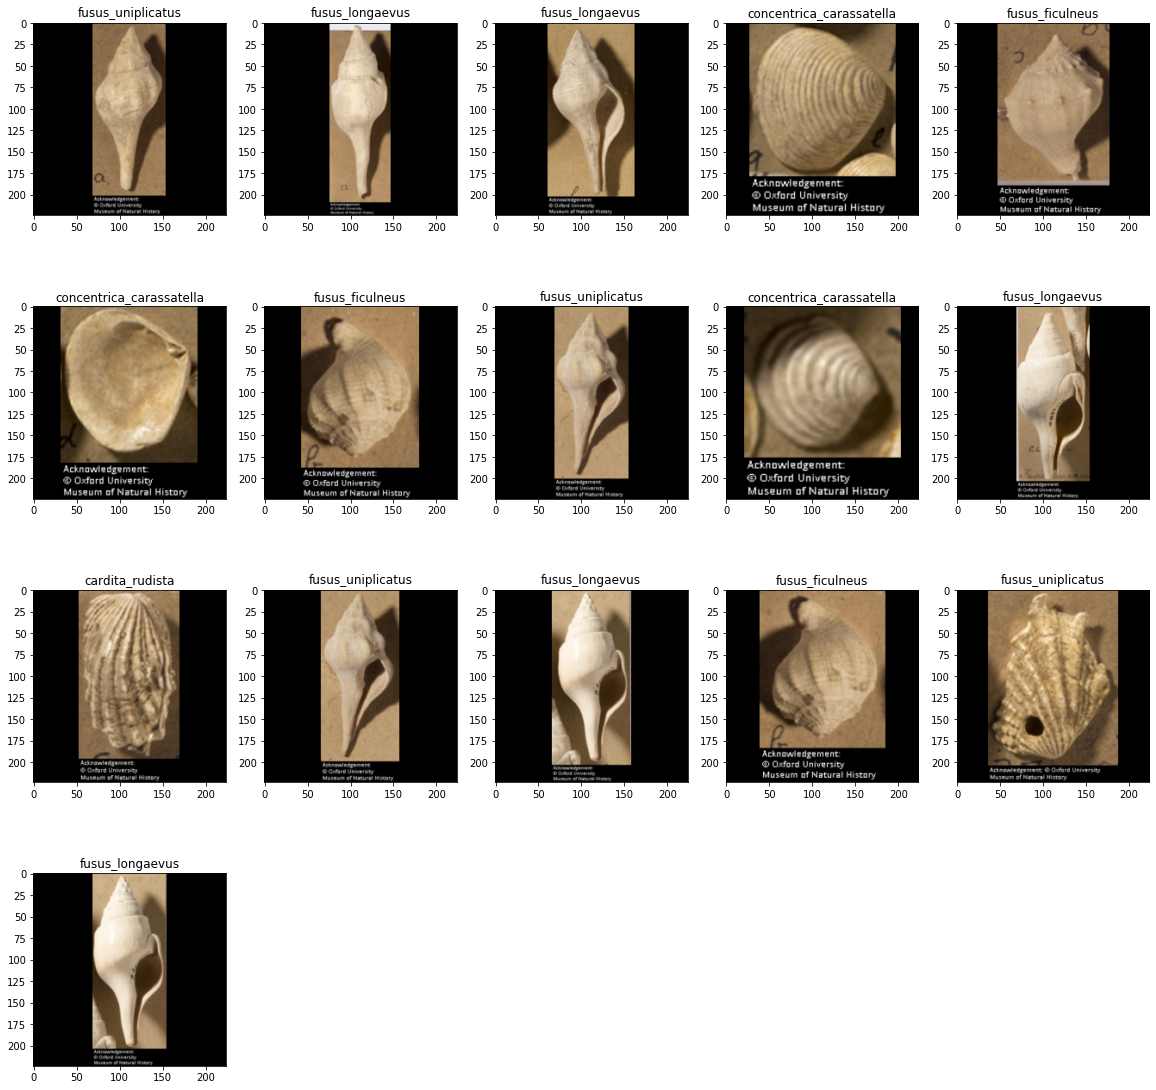

In [26]:
fig = plt.figure(figsize=(20, 20))
counter = 0
for i in image_names:
    fig.add_subplot(4,5, counter + 1)
    plt.title(predictions[counter])
    plt.imshow(Image.open(os.path.join(fossil_images_directory,image_names[counter])), interpolation='bilinear') # show original image
    #plt.imshow(batch_holder[counter]/256.) # or show image data from array used by classifier
    counter += 1
plt.show()
  

### Save the predictions (to a CSV file)

In [27]:
f = open(output_file, "a")
f.write('File,Prediction\n')
for i in image_names:
    f.write(image_names[i] + ',' + predictions[i] + '\n')
f.close()


### Cleanup

In [28]:
ih.removeTemporaryDirectory('../temp_validation')
